In [14]:
from torch.nn.functional import embedding

# 定义一个句子列表
sentences = [
    "Kage is Teacher",
    "Mazaong is Boss",
    "Niuzong is Boss",
    "Xiaobing is Student",
    "Xiaoxue is Student",
]
# 将所有的句子连接在一起，然后使用空格分割多个单词
words = " ".join(sentences).split()
# 构建词汇表，使用set去重
word_list = list(set(words))
# 创建一个字典，将每个词映射到唯一的索引
word_to_idx = {word: i for i, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到唯一的词
idx_to_word = {i: word for i, word in enumerate(word_list)}
voc_size = len(word_list)  # 词汇表大小
print("词汇表：", word_list)
print("词汇到索引的字典：", word_to_idx)
print("索引到词汇的字典：", idx_to_word)
print("词汇表大小：", voc_size)

词汇表： ['Teacher', 'Xiaoxue', 'Boss', 'Kage', 'is', 'Niuzong', 'Mazaong', 'Xiaobing', 'Student']
词汇到索引的字典： {'Teacher': 0, 'Xiaoxue': 1, 'Boss': 2, 'Kage': 3, 'is': 4, 'Niuzong': 5, 'Mazaong': 6, 'Xiaobing': 7, 'Student': 8}
索引到词汇的字典： {0: 'Teacher', 1: 'Xiaoxue', 2: 'Boss', 3: 'Kage', 4: 'is', 5: 'Niuzong', 6: 'Mazaong', 7: 'Xiaobing', 8: 'Student'}
词汇表大小： 9


In [15]:
# 定义CBOW训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split() # 将句子分割成单词
        for idx, word in enumerate(sentence): # 遍历每个单词
            # 获取上下文词汇
            context_words = sentence[max(0, idx - window_size): idx] + sentence[idx + 1: min(len(sentence), idx + window_size + 1)]
            data.append((word, context_words))
    return data
# 创建CBOW训练数据
cbow_data = create_cbow_dataset(sentences)
print("CBOW训练数据（未编码）：", cbow_data[:5])

CBOW训练数据（未编码）： [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is']), ('Mazaong', ['is', 'Boss']), ('is', ['Mazaong', 'Boss'])]


In [16]:
# 定义One-hot编码函数
import torch
def one_hot_encoding(word, word_to_idx):
    one_hot = torch.zeros(len(word_to_idx))
    one_hot[word_to_idx[word]] = 1
    return one_hot

In [17]:
# 定义CBOW模型
import torch.nn as nn
class CBOW(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层
        self.input_to_hidden = nn.Linear(voc_size, emb_size, bias=False)
        # 从嵌入大小到词汇表大小的线性层
        self.hidden_to_output = nn.Linear(emb_size, voc_size, bias=False)
    def forward(self, X): # X: [num_context_words, voc_size]
        embeddings = self.input_to_hidden(X) # x: [num_context_words, emb_size]
        # 计算隐藏层的平均值 [1, emb_size]
        hidden = embeddings.mean(dim=0, keepdim=True)
        # 计算输出层 [1, voc_size]
        output = self.hidden_to_output(hidden)
        return output
embedding_size = 2
cbow_model = CBOW(voc_size, embedding_size)
print(cbow_model)

CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.1926068464914956
Epoch: 200, Loss: 2.183696715037028
Epoch: 300, Loss: 2.174105707804362
Epoch: 400, Loss: 2.1631932258605957
Epoch: 500, Loss: 2.1502254645029706
Epoch: 600, Loss: 2.134325369199117
Epoch: 700, Loss: 2.1144275506337484
Epoch: 800, Loss: 2.0892490704854327
Epoch: 900, Loss: 2.057297174135844
Epoch: 1000, Loss: 2.0169543345769245


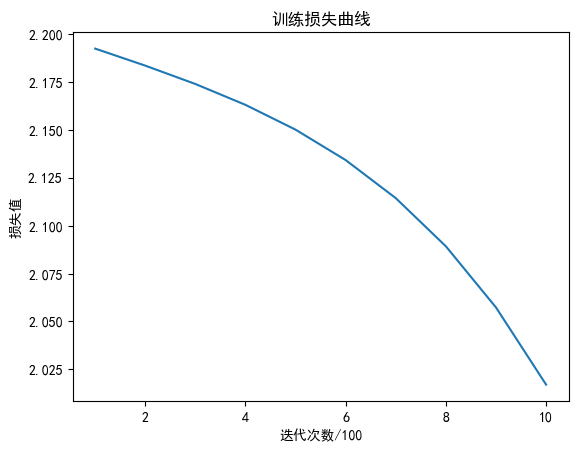

In [18]:
# 训练
learning_rate = 0.001  # 学习率
epochs = 1000  # 迭代次数
criterion = nn.CrossEntropyLoss()  # 损失函数
import torch.optim as optim # 优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)  # 随机梯度下降优化器
# 开始训练
loss_values = []  # 保存损失值
for epoch in range(epochs):
    loss_sum = 0
    for target, context_words in cbow_data:
        # 将上下文词转化为One-Hot编码后的向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float()
        # 将目标词转化为索引值
        y_true = torch.tensor([word_to_idx[target]])
        y_pred = cbow_model(X)  # 前向传播
        loss = criterion(y_pred, y_true) # 计算损失
        loss_sum += loss.item() # 累加损失
        optimizer.zero_grad() # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step() # 更新参数
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss_sum/len(cbow_data)}")
        loss_values.append(loss_sum / len(cbow_data))
# 绘制损失曲线
import matplotlib.pyplot as plt
# 绘制二维向量图
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 显示负号
plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("迭代次数/100")
plt.ylabel("损失值")
plt.show()

In [19]:
# 输出CBOW模型的词向量
print("CBOW模型的词向量：")
for word, idx in word_to_idx.items():
    print(f"{word}: {cbow_model.input_to_hidden.weight[:, idx].detach().numpy()}")

CBOW模型的词向量：
Teacher: [-0.01547731  0.03173968]
Xiaoxue: [ 0.06060189 -0.01548139]
Boss: [ 0.2964497 -0.9789261]
Kage: [-0.25034556 -0.46009368]
is: [-0.1728663  0.3344439]
Niuzong: [ 0.05020529 -0.16423483]
Mazaong: [-0.16396129 -0.05368442]
Xiaobing: [-0.06647447  0.05720341]
Student: [ 0.7241322  -0.35698572]


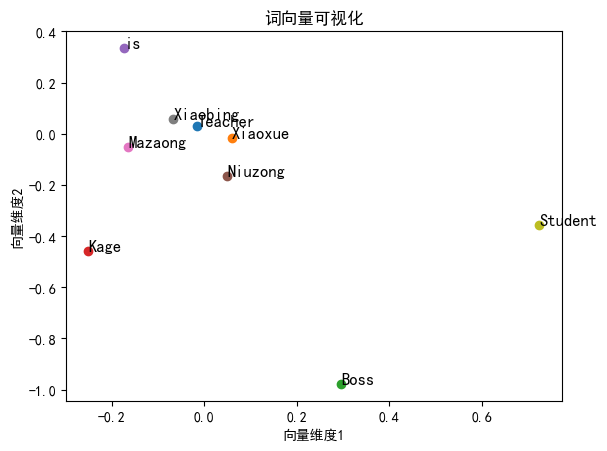

In [20]:
# 可视化词向量
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    # 获取词向量
    vec = cbow_model.input_to_hidden.weight[:, idx].detach().numpy()
    ax.scatter(vec[0], vec[1]) # 绘制点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 添加标签
plt.title("词向量可视化")
plt.xlabel("向量维度1")
plt.ylabel("向量维度2")
plt.show()